# Laboratorio 10 - Regresión Logistica

En este ejercicio se implementa regresion logistica y se aplica al dataset de [Paris Housing Classification](https://www.kaggle.com/datasets/mssmartypants/paris-housing-classification)

Para poder trabajar primero se modifico la columna de 'category' que es nuestra y que clasifica si la vivienda es de lujo (1) o basica(0), despues se normalizo los datos para poder trabajar ya que existen valores mus distantes el uno con el otro, y despues se procedio a modificar los valores del coeficiente de aprendizaje y la cantidad de iteraciones


In [89]:
# se utiliza para el manejo de rutas y directorios.
import os

# Calculo cientifico y vectorial para python
import numpy as np
import pandas as pd
import math

# Librerias para graficar
from matplotlib import pyplot

# Modulo de optimización de scipy
from scipy import optimize

# le dice a matplotlib que incruste gráficos en el cuaderno
%matplotlib inline

## 1 Regresion Logistica

Con los datos de una vivienda que son: metros cuadrados, número de habitaciones, tiene patio, tiene piscina, número de plantas, código postal, cityPartRange, más exclusivo es el vecindario, número de propietarios anteriores, año construido, es Nuevo Construido, tiene Protector de tormentas, metros cuadrados de sótano,  metros cuadrados de ático, tamaño del garaje, tiene Almacenamiento, número de habitaciones, recio de una casa, con datos del dataset se puede aplicar la regresion logísica, se tiene la categoría (Lujo o Básica) como y.

La siguiente celda cargará los datos y las etiquetas correspondientes:

In [142]:
dataN = pd.read_csv('Data/ParisHousingClass.csv', sep=',')
dataN['category'] = dataN['category'].map({'Basic': 0, 'Luxury': 1})
cero = 0.12345
cc = list(dataN.columns)
# reordena las columnas
listaColumnas = []
listaColumnasFinal = []
listaColumnasInicio = []
for j in range(len(cc)-1):
    cantidad = len(dataN[cc[j]].unique())
    if cantidad <= 2:
        listaColumnasFinal.append(cc[j])
    else:
        listaColumnasInicio.append(cc[j])
listaColumnas = listaColumnasInicio + listaColumnasFinal
listaColumnas.append(cc[len(cc)-1])
dataN = dataN.reindex(columns=listaColumnas)
data = dataN.to_numpy()

In [143]:
# Cargar datos
X, y = data[:, 0:17], data[:, 17]
m, n = X.shape

### 1.1 Visualizar los datos

Antes de comenzar a implementar cualquier algoritmo de aprendizaje, siempre es bueno visualizar los datos si es posible. Mostramos los datos en una gráfica bidimensional llamando a la función `plotData`. Se completará el código en `plotData` para que muestre una figura donde los ejes son los dos puntajes de los dos examenes, los ejemplos positivos y negativos se muestran con diferentes marcadores.

In [47]:
def plotData(X, y):
    # Gragica los puntos de datos X y y en una nueva figura. Grafica los puntos de datos con * para los positivos y 
    # o para los negativos.
    
    # Crea una nueva figura
    fig = pyplot.figure()

    # Find Indices of Positive and Negative Examples
    pos = y == 1
    neg = y == 0

    # Plot Examples
    pyplot.plot(X[pos, 0], X[pos, 1], X[pos, 2], X[pos, 4], X[pos, 5], X[pos, 6], X[pos, 7], X[pos, 8], X[pos, 9], X[pos, 10], X[pos, 11], 'k*', lw=2, ms=10)
    pyplot.plot(X[neg, 0], X[neg, 1], X[neg, 2], X[neg, 4], X[neg, 5], X[neg, 6], X[neg, 7], X[neg, 8], X[neg, 9], X[neg, 10], X[neg, 11], 'ko', mfc='y', ms=8, mec='k', mew=1)
    

Se llama a la función implementada para mostrar los datos cargados:

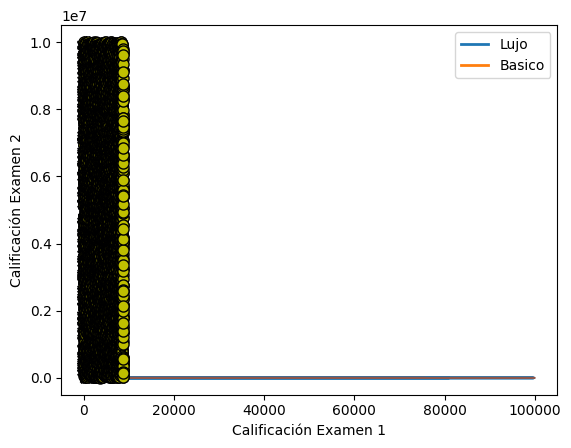

In [144]:
plotData(X, y)
# adiciona etiquetas para los ejes
pyplot.xlabel('Calificación Examen 1')
pyplot.ylabel('Calificación Examen 2')
pyplot.legend(['Lujo', 'Basico'])
pass

<a id="section1"></a>
### 1.2 Implementacion

#### 1.2.1 Función Sigmoidea

La hipotesis para la regresión logistica se define como:

$$ h_\theta(x) = g(\theta^T x)$$

donde la función $g$ is la función sigmoidea. La función sigmoidea se define como: 

$$ g(z) = \frac{1}{1+e^{-z}}$$

Los resultados que debe generar la funcion sigmoidea para valores positivos amplios de `x`, deben ser cercanos a 1, mientras que para valores negativos grandes, la sigmoide debe generar valores cercanos 0. La evaluacion de `sigmoid(0)` debe dar un resultado exacto de 0.5. Esta funcion tambien debe poder trabajar con vectores y matrices.

In [145]:
def  featureNormalize(X):
    X_norm = X.copy()
    mu = np.zeros(X.shape[1])
    sigma = np.zeros(X.shape[1])

    mu = np.mean(X, axis = 0)
    sigma = np.std(X, axis = 0)
    X_norm = (X - mu) / sigma
    
    return X_norm, mu, sigma

In [146]:
X_norm, mu, sigma = featureNormalize(X)
X = np.concatenate([np.ones((m, 1)), X_norm], axis=1)

In [147]:
def sigmoid(z):
    z = np.array(z)
    g = np.zeros(z.shape)
    g = 1 / (1 + np.exp(-z))
    return g

<a id="section2"></a>
#### 1.2.2 Función de Costo y Gradiente

Se implementa la funcion cost y gradient, para la regresión logistica. Antes de continuar es importante agregar el termino de intercepcion a X. 

La funcion de costo en una regresión logistica es:

$$ J(\theta) = \frac{1}{m} \sum_{i=1}^{m} \left[ -y^{(i)} \log\left(h_\theta\left( x^{(i)} \right) \right) - \left( 1 - y^{(i)}\right) \log \left( 1 - h_\theta\left( x^{(i)} \right) \right) \right]$$

y el gradiente del costo es un vector de la misma longitud como $\theta$ donde el elemento $j^{th}$ (para $j = 0, 1, \cdots , n$) se define como:

$$ \frac{\partial J(\theta)}{\partial \theta_j} = \frac{1}{m} \sum_{i=1}^m \left( h_\theta \left( x^{(i)} \right) - y^{(i)} \right) x_j^{(i)} $$

Si bien este gradiente parece idéntico al gradiente de regresión lineal, la fórmula es diferente porque la regresión lineal y logística tienen diferentes definiciones de $h_\theta(x)$.
<a id="costFunction"></a>

In [155]:
def calcularCosto(theta, X, y):
    m = y.size
    h = sigmoid(X.dot(theta.T))
    J = (1 / m) * np.sum(-(y).dot(np.log(h)) - ((1 - y)).dot(np.log(1-h)))
    return J

In [149]:
def descensoGradiente(theta, X, y, alpha, num_iters):
    m = y.shape[0]
    theta = theta.copy()
    J_history = []
    
    for i in range(num_iters):
        h = sigmoid(X.dot(theta.T))
        theta = theta - (alpha / m) * (h - y).dot(X)
        J_history.append(calcularCosto(theta, X, y))
    return theta, J_history

theta calculado por el descenso por el gradiente: [-7.18540657e+00 -4.34549264e-03 -1.81018194e-03 -6.47123718e-03
 -4.15499263e-03 -1.27414488e-02 -1.12600352e-02  6.03664570e-03
  1.54309246e-04 -7.33239710e-03 -7.36559569e-03 -3.24291431e-03
 -6.94323568e-04  3.46623790e+00  3.47414074e+00  3.49432328e+00
  1.21526823e-02  9.75644933e-03]
Costo Min:  0.01382431365975333
Una vivienda con las siguientes caracteristicas:
[1, 2475, 47, 37, 11367, 9, 2, 2012, 3061, 7432, 328, 5, 254501.2, 1, 1, 1, 1, 0]
Con el descenso por el gradiente, tiena una probabilidad de 96.23% de ser de lujo


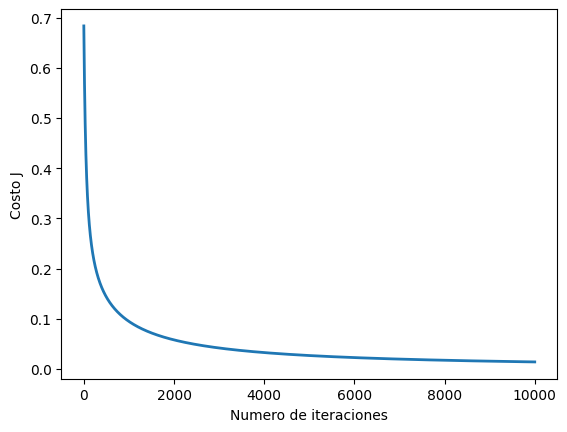

In [166]:
# Elegir algun valor para alpha (probar varias alternativas)
alpha = 0.05
num_iters = 10000

theta = np.zeros(n+1)
theta, J_history = descensoGradiente(theta, X, y, alpha, num_iters)
ejeX = np.arange(len(J_history))
ejeY = J_history
pyplot.plot(ejeX, ejeY, lw=2)
pyplot.xlabel('Numero de iteraciones')
pyplot.ylabel('Costo J')

print('theta calculado por el descenso por el gradiente: {:s}'.format(str(theta)))
print('Costo Min: ', np.min(J_history))
X_array = [1,2475,47,37,11367,9,2,2012,3061,7432,328,5,254501.2,1,1,1,1,0]
# X_array = [1,1440,84,49,18412,6,10,1994,8485,2024,278,6,146708.4,0,0,1,0,1]
print('Una vivienda con las siguientes caracteristicas:')
print(X_array)
X_array[1:18] = (X_array[1:18] - mu) / sigma
aprueba = sigmoid(np.dot(X_array, theta))
print('Con el descenso por el gradiente, tiena una probabilidad de {:.2f}%'.format(aprueba*100), 'de ser de lujo')

In [167]:
def costFunction(theta, X, y):
    m = y.size
    J = 0
    grad = np.zeros(theta.shape)
    h = sigmoid(X.dot(theta.T))
    J = (1 / m) * np.sum(-y.dot(np.log(h)) - (1 - y).dot(np.log(1 - h)))
    grad = (1 / m) * (h - y).dot(X)
    
    return J, grad

Se prueba la funcion `costFunction` utilizando dos casos de prueba para $\theta$.

In [168]:
# Inicializacion de parametros de ajuste
initial_theta = np.zeros(n+1)
print(initial_theta)
cost, grad = costFunction(initial_theta, X, y)

print('Costo en theta inicial (zeros): {:.3f}'.format(cost))
print(grad)
print('Gradiente en theta inicial (zeros):')
print('\t[{:.4f}, {:.4f}, {:.4f}, {:.4f}, {:.4f}, {:.4f}, {:.4f}, {:.4f}, {:.4f}, {:.4f}, {:.4f}, {:.4f}]'.format(*grad))



[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Costo en theta inicial (zeros): 0.693
[ 3.73500000e-01  3.92232459e-03  1.47060990e-04  1.27223406e-03
 -1.31292578e-03  1.05423952e-03  4.26919227e-03 -1.79473834e-03
  3.75961103e-03  1.90424460e-03  7.37421626e-04 -1.03363995e-03
  3.78923946e-03 -1.24317721e-01 -1.27312207e-01 -1.26727905e-01
 -7.25300015e-04 -7.41013338e-04]
Gradiente en theta inicial (zeros):
	[0.3735, 0.0039, 0.0001, 0.0013, -0.0013, 0.0011, 0.0043, -0.0018, 0.0038, 0.0019, 0.0007, -0.0010]


In [170]:
# Calcula y muestra el costo y el gradiente con valores de theta diferentes a cero

test_theta = np.array([-5,-6,6,-8,1,-8,12,69,-42,62,65,63,-14,-42,62,65,63,-14])
print(test_theta)
cost, grad = costFunction(test_theta, X, y)

print('Costo en theta prueba: {:.3f}'.format(cost))

print('Gradiente en theta prueba:')
print('\t[{:.4f}, {:.4f}, {:.4f}, {:.4f}, {:.4f}, {:.4f}, {:.4f}, {:.4f}, {:.4f}, {:.4f}, {:.4f}, {:.4f}, {:.4f}]'.format(*grad))

[ -5  -6   6  -8   1  -8  12  69 -42  62  65  63 -14 -42  62  65  63 -14]
Costo en theta prueba: nan
Gradiente en theta prueba:
	[0.3592, -0.0414, 0.0271, -0.0184, 0.0002, -0.0127, 0.0280, 0.1483, -0.0947, 0.1362, 0.1436, 0.1375, -0.0415]


C:\Users\TUF GAMING\AppData\Local\Temp\ipykernel_16148\4029448925.py:6: RuntimeWarning: divide by zero encountered in log
  J = (1 / m) * np.sum(-y.dot(np.log(h)) - (1 - y).dot(np.log(1 - h)))


#### 1.2.3 Parámetros de aprendizaje usando `scipy.optimize`

En el codigo anterior se encontró los parámetros óptimos de un modelo de regresión lineal al implementar el descenso de gradiente. Se implemento una función de costo y se calculó su gradiente, utilizando el algoritmo del descenso por el gradiente.

En lugar de realizar los pasos del descenso por el gradiente, se utilizará el [módulo `scipy.optimize`] (https://docs.scipy.org/doc/scipy/reference/optimize.html). SciPy es una biblioteca de computación numérica para `python`. Proporciona un módulo de optimización para la búsqueda y minimización de raíces. A partir de `scipy 1.0`, la función` scipy.optimize.minimize` es el método a utilizar para problemas de optimización (tanto restringidos como no restringidos).

For logistic regression, you want to optimize the cost function $J(\theta)$ with parameters $\theta$.
Concretely, you are going to use `optimize.minimize` to find the best parameters $\theta$ for the logistic regression cost function, given a fixed dataset (of X and y values). You will pass to `optimize.minimize` the following inputs:

Para la regresión logística, se desea optimizar la función de costo $J(\theta)$ con los parámetros $\theta$.
Concretamente, se va a utilizar `optimize.minimize` para encontrar los mejores parámetros $\theta$ para la función de costo de regresión logística, dado un dataset fijo (de valores X e y). Se pasara a `optimize.minimize` las siguientes entradas:

- `costFunction`: Una función de costo que, cuando se le da el dataset de entrenamiento y un $\theta$ particular, calcula el costo de regresión logística y el gradiente con respecto a $\theta$ para el dataset(X, y). Es importante tener en cuenta que solo se pasa el nombre de la función sin el paréntesis. Esto indica que solo proporcionamos una referencia a esta función y no evaluamos el resultado de esta función.
- `initial_theta`: Los valores iniciales de los parametros que se tratan de optimizar.
- `(X, y)`: Estos son argumentos adicionales a la funcion de costo.
- `jac`: Indicación si la función de costo devuelve el jacobiano (gradiente) junto con el valor de costo. (True)
- `method`: Método / algoritmo de optimización a utilizar
- `options`: Opciones adicionales que pueden ser específicas del método de optimización específico. Solo se indica al algoritmo el número máximo de iteraciones antes de que termine.

Si se ha completado la `costFunction` correctamente,`optimize.minimize` convergerá en los parámetros de optimización correctos y devolverá los valores finales del costo y $\theta$ en un objeto de clase.

Al usar `optimize.minimize`, no se tuvo que escribir ningún bucle ni establecer una tasa de aprendizaje como se hizo para el descenso de gradientes. Todo esto se hace mediante `optimize.minimize`: solo se necesita proporcionar una función que calcule el costo y el gradiente.

A continuación, se tiene el código para llamar a `optimize.minimize` con los argumentos correctos.

In [171]:
# Establecer las opciones para optimize.minimize
options= {'maxiter': 1000}

# revisar la documentacion de scipy's optimize.minimize para mayor descripcion de los parametros
# La funcion devuekve un objeto `OptimizeResult`
# Se utiliza el algoritmo de Newton truncado para la optimización.
res = optimize.minimize(costFunction,
                        initial_theta,
                        (X, y),
                        jac=True,
                        method='TNC',
                        options=options)

# la propiedad fun del objeto devuelto por `OptimizeResult`
# contiene el valor del costFunction de un theta optimizado
cost = res.fun

# Theta optimizada esta en la propiedad x
theta = res.x

# Imprimir theta en la pantalla
print('Costo con un valor de theta encontrado por optimize.minimize: {:.3f}'.format(cost))

print('theta: ')
print('\t[{:.3f}, {:.3f}, {:.3f}, {:.3f}, {:.3f}, {:.3f}, {:.3f}, {:.3f}, {:.3f}, {:.3f}, {:.3f}, {:.3f}, {:.3f}]'.format(*theta))

Costo con un valor de theta encontrado por optimize.minimize: 0.000
theta: 
	[-32.369, -0.042, -0.065, 0.026, -0.120, -0.121, 0.066, -0.051, 0.092, -0.009, 0.002, -0.116, -0.025]


C:\Users\TUF GAMING\AppData\Local\Temp\ipykernel_16148\1627100581.py:7: DeprecationWarning: 'maxiter' has been deprecated in favor of 'maxfun' and will be removed in SciPy 1.11.0.
  res = optimize.minimize(costFunction,


Una vez que se completa `optimize.minimize`, se usa el valor final de $\theta$ para visualizar el límite de decisión en los datos de entrenamiento.

Para hacerlo, se implementa la función `plotDecisionBoundary` para trazar el límite de decisión sobre los datos de entrenamiento.

In [172]:
def plotDecisionBoundary(plotData, theta, X, y):
    """
    Grafica los puntos X y Y en una nueva figura con un limite de desicion definido por theta.
    the data points X and y into a new figure with the decision boundary defined by theta.
    Grafica los puntos con * para los ejemplos positivos y con o para los ejemplos negativos.
    
    Parametros:
    ----------
    plotData : func
        A function reference for plotting the X, y data.

    theta : array_like
        Parametros para la regresion logistica. Un vecto de la forma (n+1, ).

    X : array_like
        Data set de entrada. Se supone que X es una de las siguientes:
            1) Matriz Mx3, donde la primera columna es una columna de unos para intercepción.
            2) Matriz MxN, N> 3, donde la primera columna son todos unos.

    y : array_like
        Vector de datos de etiquetas de la forma (m, ).
    """
    # hacer que theta sera un arreglo numpy
    theta = np.array(theta)

    # Graficar los datos (recordar que la primera columna en X es la intercepción)
    plotData(X[:, 1:3], y)

    if X.shape[1] <= 3:
        # Solo se requieren 2 puntos para definir una linea, para lo cual se eligen dos puntos finales
        plot_x = np.array([np.min(X[:, 1]) - 2, np.max(X[:, 1]) + 2])

        # Calcular la línea límite de decisión
        plot_y = (-1. / theta[2]) * (theta[1] * plot_x + theta[0])

        print(plot_x)
        print(plot_y)
        # Graficar y ajustar los ejes para una mejor visualización
        pyplot.plot(plot_x, plot_y)

        # Leyenda, especifica para el ejercicio
        pyplot.legend(['Admitido', 'No admitido', 'Limite de decisión'])
        pyplot.xlim([30, 100])
        pyplot.ylim([30, 100])
    else:
        # Rango de la grilla
        u = np.linspace(-1, 1.5, 50)
        v = np.linspace(-1, 1.5, 50)

        z = np.zeros((u.size, v.size))
        # Evalua z = theta*x sobre la grilla
        for i, ui in enumerate(u):
            for j, vj in enumerate(v):
                z[i, j] = np.dot(mapFeature(ui, vj), theta)

        z = z.T  # importante transponer z antes de llamar al contorno
        # print(z)

        # Plot z = 0
        pyplot.contour(u, v, z, levels=[0], linewidths=2, colors='g')
        pyplot.contourf(u, v, z, levels=[np.min(z), 0, np.max(z)], cmap='Greens', alpha=0.4)


In [ ]:
# Graficar limites
plotDecisionBoundary(plotData, theta, X, y)

<a id="section4"></a>
#### 1.2.4 Evaluación de la regresión logistica

Después de aprender los parámetros, se puede usar el modelo para predecir si un estudiante en particular será admitido. Para un estudiante con una puntuación en el Examen 1 de 45 y una puntuación en el Examen 2 de 85, debe esperar ver una probabilidad de admisión de 0,776. Otra forma de evaluar la calidad de los parámetros que hemos encontrado es ver qué tan bien predice el modelo aprendido en nuestro conjunto de entrenamiento. 

In [173]:
def predict(theta, X):
    """
    Predecir si la etiqueta es 0 o 1 mediante regresión logística aprendida.
    Calcula las predicciones para X usando un umbral en 0.5 (es decir, si sigmoide (theta.T * x)> = 0.5, predice 1)

    Parametros
    ----------
    theta : array_like
        Parametros para regresion logistica. Un vecto de la forma (n+1, ).
    
    X : array_like
        Datos utilizados para el calculo de las predicciones. 
        La fila es el numero de los puntos para calcular las predicciones, 
        y las columnas con el numero de caracteristicas.

    Devuelve
    -------
    p : array_like
        Predicciones y 0 o 1 para cada fila en X. 
    """
    m = X.shape[0] # Numero de ejemplo de entrenamiento

    p = np.zeros(m)

    p = np.round(sigmoid(X.dot(theta.T)))
    return p

Una vez entrenado el modelo se procede a realizar la prediccion y evaluación de los resultados de predecir cual es el valor que vota el modelo para todos los datos utilizados en el entrenamiento.

In [174]:
X_prueba = [1,1440,84,49,18412,6,10,1994,8485,2024,278,6,146708.4,0,0,1,0,1]
prob = sigmoid(np.dot(X_prueba, theta))
print('Una vivienda con las siguientes caracteristicas:')
print(X_array)
print('Con el descenso por el gradiente, tiena una probabilidad de {:.2f}%'.format(prob * 100), 'de ser de lujo')

# Compute accuracy on our training set
p = predict(theta, X)
print('Precisión de entrenamiento: {:.2f} %'.format(np.mean(p == y) * 100))

Una vivienda con las siguientes caracteristicas:
[1, -1.6472121655916527, -0.11654937434729953, -0.45958271838924153, -1.3397063985864741, 1.2151967739664413, -1.2328620569983992, 0.6995877657728833, -0.6855710562530966, 0.8306266987361712, -0.8591196754355361, 0.0017001174926847859, -1.6470228613359945, 0.9827487797722753, 1.0064206117051937, 1.0018016229199438, 1.0002000200040004, -1.0060181084889308]
Con el descenso por el gradiente, tiena una probabilidad de 0.00% de ser de lujo
Precisión de entrenamiento: 100.00 %


C:\Users\TUF GAMING\AppData\Local\Temp\ipykernel_16148\1793552007.py:4: RuntimeWarning: overflow encountered in exp
  g = 1 / (1 + np.exp(-z))
